In [1]:
import yaml
import os

import time
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from stopping_time_model import *

In [2]:
dataset_name = "Ts_in_out_data.csv"
df = pd.read_csv(dataset_name)
df.head()

,Position,Velocity,u_max,w_max,d_init,Ts
0,-29.497804,25.730363,3,2.424731,-29.384002,0.293422
1,-29.394451,25.838412,3,2.424731,-29.279022,0.294310
2,-29.290666,25.946208,3,2.424731,-29.174402,0.295194
3,-29.186457,26.052289,3,2.424731,-29.069078,0.296131
4,-29.081801,26.163908,3,2.424731,-28.964766,0.297064


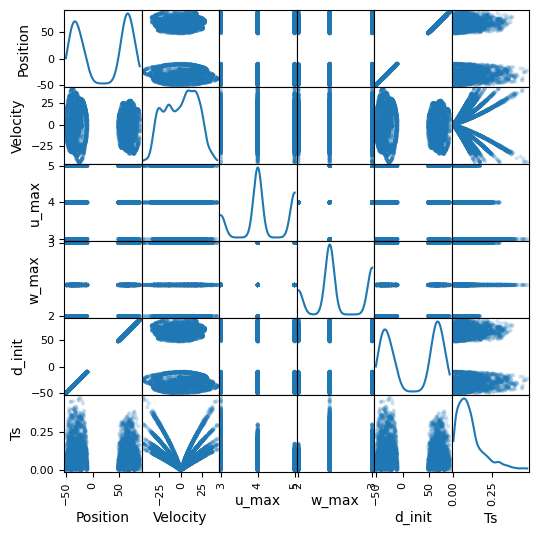

In [3]:
train_df, test_df = train_test_split(df, train_size = 0.8)
test_df, eval_df = train_test_split(test_df, train_size = 0.5)

scatter_matrix(eval_df, alpha=0.2, figsize=(6, 6), diagonal="kde");

In [4]:
input_cols = ['Velocity', 'u_max', 'w_max']
target_cols = ['Ts']

train_dataset = TsDataset(train_df, input_cols, target_cols)
test_dataset = TsDataset(test_df, input_cols, target_cols)
eval_dataset = TsDataset(eval_df, input_cols, target_cols)

In [5]:
## dataloaders
batch_size = 128 * 2

## optimizer and scheduler
learning_rate = 1e-3 #1e-4 #5e-4
minimum_learning_rate = 1e-10
epoch_num = 24 #16 # 40
step_size = 4
gamma = 0.1
decay = 1e-2

# models params
input_channels = [0]
condition_features = 1
condition_channels = [1, 2]
output_channels = [0]
projection_features = 8 #4 #8
hidden_features = 64 #32
dropout_alpha = 0.2


In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size = batch_size, shuffle = False)

model = Linear_Conditioner(input_channels, condition_features, condition_channels, output_channels, projection_features, hidden_features, dropout_alpha = dropout_alpha)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

model = model.double()

### train network
results_dictionary, model = trainModel(model, train_dataloader, test_dataloader, 
                                        optimizer, scheduler, epochs = epoch_num)

full_eval_loss = testLoop(model, eval_dataloader)

Epoch 0
-------------------------------
Loss rate: 1.1518839844814798e-07
Training time: 5.654980182647705
Mean loss: 0.00011518839844814798
Epoch 1
-------------------------------
Loss rate: 0.18354991887514902
Training time: 5.520225524902344
Mean loss: 2.1142821190515902e-05
Epoch 2
-------------------------------
Loss rate: 0.5298714248459789
Training time: 5.525019884109497
Mean loss: 1.1202976789482417e-05
Epoch 3
-------------------------------
Loss rate: 0.709948602083166
Training time: 5.6293206214904785
Mean loss: 7.953537710863198e-06
Epoch 4
-------------------------------
Loss rate: 0.9705610048906211
Training time: 5.547200918197632
Mean loss: 7.719393553090836e-06
Epoch 5
-------------------------------
Loss rate: 0.9865889529006923
Training time: 5.6009275913238525
Mean loss: 7.615868402572242e-06
Epoch 6
-------------------------------
Loss rate: 0.9839074275569419
Training time: 5.576495170593262
Mean loss: 7.493309488587051e-06
Epoch 7
-------------------------------

In [7]:
save_name = "ts_model"
config_dict = {"input_channels": input_channels,
                "condition_features": condition_features,
                "condition_channels": condition_channels,
                "output_channels": output_channels,
                "projection_features": projection_features,
                "hidden_features": hidden_features,
                "dropout_alpha": dropout_alpha,
                "eval_loss": full_eval_loss}

torch.save(model.state_dict(), save_name + ".pt")
with open(save_name + "_config.yaml", 'w') as outfile:
        yaml.dump(config_dict, outfile)

inf_model_no_comp = TsModelWrapper(save_name, compile_model = False)
inf_model = TsModelWrapper(save_name)


Did not compile model!
Inference time: 0.0020304710865020753 +/- 0.0002356372867274979s (May vary depending on background processes)
Expected stopping time prediction error: 0.006703774994160269ms
Compiled model!
Inference time: 0.0006703646183013916 +/- 0.00020164337591175056s (May vary depending on background processes)
Expected stopping time prediction error: 0.006703774994160269ms
